# SVD and Latent Semantic Analysis (LSA)

Singular Value Decomposition (SVD) applied to text documents is often referred to as _Latent Semantic Analysis_ (LSA).

Let's $A$ be our $N \times n$ feature matrix with $N$ samples and $n$ features, and let's write the SVD as follows, trunacted to some dimension $k < n$:

\begin{align}
A = U \Sigma V^{T}
\end{align}

Each of these matrices represents some grouping the data:
- $U$ ($N \times k$) represents how each datapoint relates to some latent concept,
- $V$ ($n \times k$) represents how each concept relates to each original feature ($V^T$ would be $k \times n$) 
- $\Sigma$ ($k \times k$) represents the strength of each of those concepts in the dataset.

This reduces the number of dimensions from $n$ to $k$, since instead of modelling our data for each feature, we now model our data for each concept. Our intuition is that datapoints with similar relevant features will get similar concepts.

A very concrete example of this is text classification, in which case this method is often called _Latent Semantic Analysis_ (LSA).  As always with Natural Language Processing (NLP), we transform our $N$ documents into a $N \times n$ feature matrix, where each column represents a certain word or n-gram (e.g., using `CountVectorizer`).  

This notebook demonstrates SVD and LSA with a simple example.


This example is over text, but really, you could even use this for **recommendation systems!**. If you had a matrix of users x items, where each entry is the # that they purchase, you could apply the same technique.

#### Import code and data

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space',]
dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True)

documents = dataset.data
y = dataset.target

true_k = np.unique(y).shape[0]

print "There are %d true labels" % (true_k)

There are 4 true labels


#### Feature extraction
Extract features from the training dataset using a sparse vectorizer.

In [3]:
# Remove english stop words. Remove words that 
vectorizer = CountVectorizer(stop_words='english', max_features=10000, min_df=.01, max_df=0.5)
X = vectorizer.fit_transform(documents)
n_samples, n_features = X.shape
print "Dimensions feature matrix:", X.shape

Dimensions feature matrix: (3387, 2189)


#### Dimension reduction
We could reduce the number of dimensions by performing a SVD. We hope that we could describe most of the data in a much lower-dimensional space, in which the dimensions represent topics (or concepts, or _latent semantics_) rather than just words.

In [4]:
n_components = 150

In [5]:
svd = TruncatedSVD(n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_red = lsa.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()

print "Explained variance of the SVD step: %d%%" % (explained_variance * 100)
print "Dimensions feature matrix (old):", X.shape
print "Dimensions feature matrix (new):", X_red.shape

Explained variance of the SVD step: 83%
Dimensions feature matrix (old): (3387, 2189)
Dimensions feature matrix (new): (3387, 150)


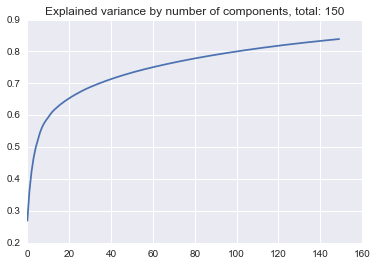

In [6]:
f = plt.plot(svd.explained_variance_ratio_.cumsum())  # these are the singular values 
f = plt.title("Explained variance by number of components, total: %d" % svd.explained_variance_ratio_.shape[0])

Great, we can describe almost 90% of our variance by just 150 dimensions, and even better, 50% of our variance by only a handful of components.

Each component is made out of a certain word combination with different weights. Let's have a look at themost important components.

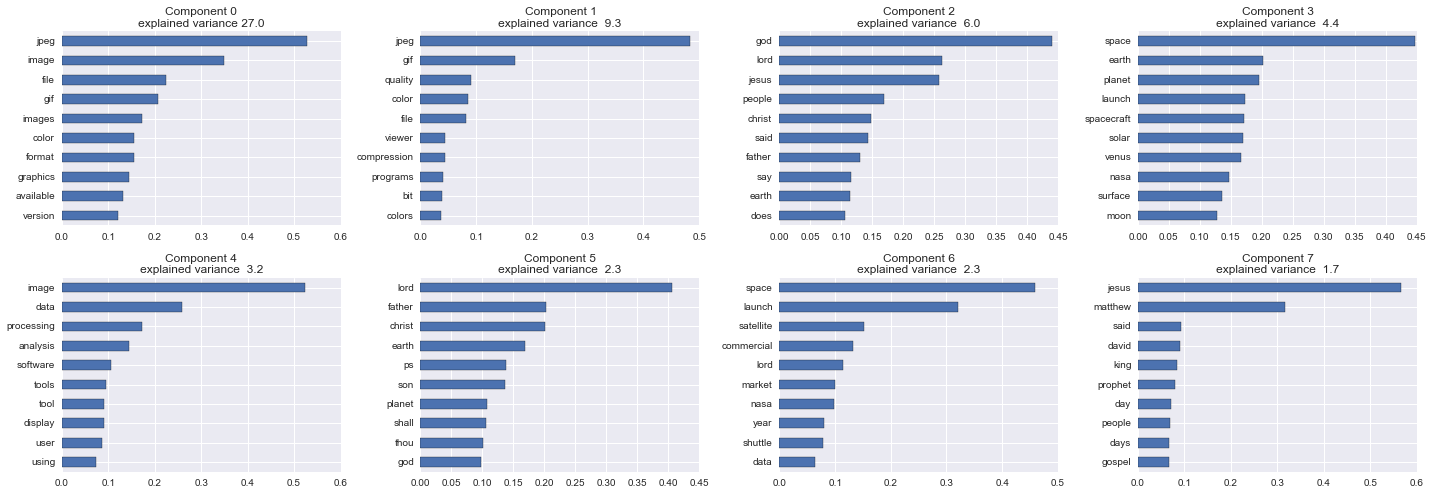

In [19]:
words = np.array(vectorizer.get_feature_names())
top_words = 10
n_rows, n_cols = 2, 4
top_components = n_rows * n_cols
plt.figure(figsize=(20,7))
for no, component in enumerate(svd.components_[:top_components]):
    plt.subplot(n_rows,n_cols,no+1)
    s = pd.Series(component, index=words).sort(inplace=False)[-top_words:]
    s.plot(kind='barh', title="Component %d\nexplained variance %4.1f" % 
           (no, 100 * svd.explained_variance_ratio_[no]))
f = plt.tight_layout()

Very clear results! 

Let's look at our documents and see how an article is represented in these dimensions.

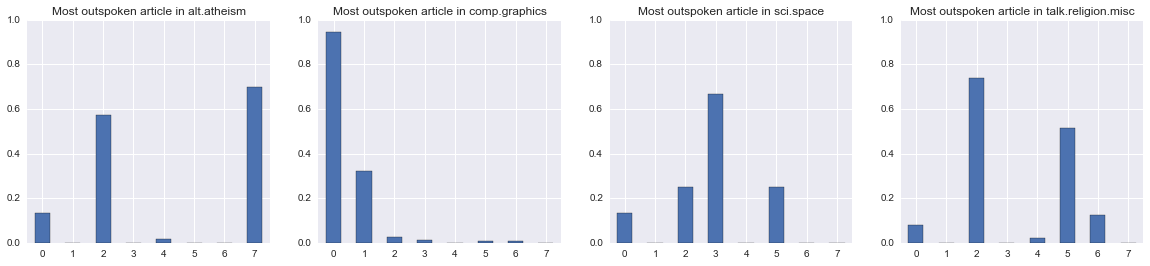

In [8]:
f, axes = plt.subplots(1, true_k, figsize=(20, 4))
for label in xrange(true_k):
    X_red_class = X_red[y == label]
    no = np.abs(X_red_class[:, :top_components]).max(axis=1).argmax()  # pick most outspoken sample
    f = pd.Series(X_red_class[no,:top_components]).plot(
        title="Most outspoken article in %s" % dataset.target_names[label],
        kind='bar', rot=0, ylim=(0, 1), ax=axes[label])

Indeed, the article has stronger representation in the component that resembles its category.

This is just data magic!